<a href="https://colab.research.google.com/github/wknowles/jupyter-notebooks/blob/master/Scans_2_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For Google Colab - install requirements and googledrive (for dxf and csv)

In [ ]:
!pip install geopandas
!pip install matplotlib
!pip install pandas
!pip install mapclassify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [212]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.ops import polygonize

#read cad file to get stand outline geometry and id
plan = gpd.read_file('simple.dxf')

#scale the DXF to spatial extend and reset origin
planScaled = plan.scale(0.01,0.01,1,origin=(0,0,0))

#apply the new scaled geometry to the geopandas dataframe
plan = gpd.GeoDataFrame(plan, geometry=planScaled)

#Drop columns that are not needed
planClean = plan.drop(columns=['PaperSpace','SubClasses','Linetype','EntityHandle'])

#Get stand outlines from ExpoCAD Layer
planLinesByLayer = planClean.loc[planClean['Layer']=='Expo_BoothOutline']
planLinesByLayer.reset_index(drop=True, inplace=True)

#Get stand IDs from ExpoCAN Layer
planPointsByLayer = planClean.loc[planClean['Layer']=='Expo_BoothNumber']
planPointsByLayer.reset_index(drop=True, inplace=True)

#create polygons from linestrings
gdf = gpd.GeoDataFrame.from_features(planLinesByLayer)
polygons = gpd.GeoSeries(polygonize(gdf.geometry))

#write polygons back into dataframe
planPolyByLayer = gpd.GeoDataFrame(planLinesByLayer, geometry=polygons)

#join tables by checking points (standID) are within polygons (standOutlines)
joinedStands = planPolyByLayer.sjoin(planPointsByLayer, how="inner", predicate="intersects")

# Clean and tidy up 
joinedCleaned = joinedStands.drop(columns=['Layer_left','Layer_right','Text_left','index_right'])
joinedCleaned.rename(columns={'Text_right':'standID'}, inplace=True)

### dwg setup complete ###

Now need to do a bit of cleaning to the lead scanning data. This comes as an excel sheet, convert to csv first. To get it to join with the stands geodataframe we need to make sure each row has one stand ID. The excel sheet shows stand IDs as an array (eg: ['2124,2313']). Use pandas dataframe with a regx to filter out the array.

In [213]:
import pandas as pd

#data = pd.read_csv("cleanScans.csv")
#floorplan = joinedCleaned.merge(data, on='standID')

df = pd.DataFrame(pd.read_csv("PGA_2023_stands.csv"))
df.stands = df.stands.str.split(',')
out = df.explode('stands')
out.stands = out['stands'].str.replace(r'[^A-Za-z0-9]+', '', regex=True)
out.rename(columns={'stands':'standID'}, inplace=True)

floorplan = joinedCleaned.merge(out, on='standID')

In [216]:

buckets = [5,10,20,50,2500]
mapStands = floorplan.explore(floorplan.no_of_scans,
                      cmap='Blues', 
                      scheme='UserDefined', 
                      classification_kwds={'bins': buckets},
                      style_kwds={'stroke':True, 'weight': 1, 'color':'#222222', 'fillOpacity':1}, 
                      legend_kwds={'caption':'Number of Scans', 'scale':True},
                      map_kwds={}
                      )
mapStands
#mapStands.save('map_by_bucket.html')


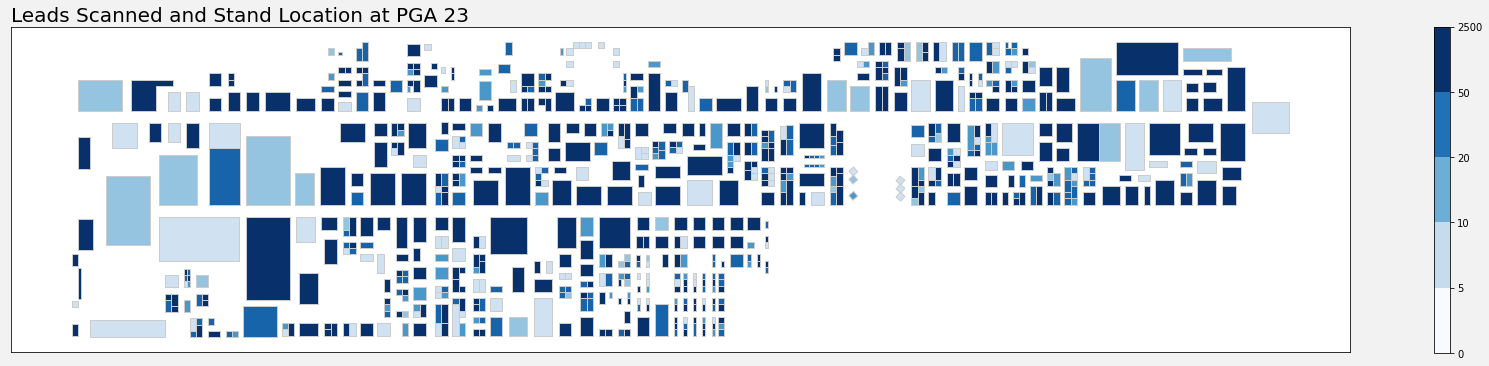

In [214]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

bins = [0,5,10,20,50,2500]
fig, ax = plt.subplots(1, figsize=(30,6))
#ax.axis('off')
fig.set_facecolor("#f2f2f2")
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.set_title('Leads Scanned and Stand Location at PGA 23 ', loc='left', fontdict={'fontsize': '20', 'fontweight' : '4'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=colors.BoundaryNorm(boundaries=bins, ncolors=256))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, location='right')
fig = floorplan.plot(floorplan.no_of_scans, scheme='UserDefined', classification_kwds={'bins': bins}, cmap="Blues", edgecolor='0.8', ax=ax)
#plt.savefig("image_filename.png", dpi=300, bbox_inches='tight')

